In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'CS229/Project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CS229/Project


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util import load_dataset
from util import place_bets
from util import evaluate_bets
from custom_loss import LogisticRegression
from custom_loss import custom_loss

import statsmodels.api as sm

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Training
x_train = load_dataset("Load_Data/x_train.csv", intercept=True)
y_train = load_dataset("Load_Data/y_train.csv").to_numpy().flatten()

# Validation
x_val = load_dataset("Load_Data/x_val.csv", intercept=True)
y_val = load_dataset("Load_Data/y_val.csv").to_numpy().flatten()

# Test
x_test = load_dataset("Load_Data/x_test.csv", intercept=True)
y_test = load_dataset("Load_Data/y_test.csv").to_numpy().flatten()

In [ ]:
# Odds data
odds_home_tr = x_train['Odds_Home'].to_numpy()
odds_away_tr = x_train['Odds_Away'].to_numpy()
odds_home_val = x_val['Odds_Home'].to_numpy()
odds_away_val = x_val['Odds_Away'].to_numpy()

## Feature Engineering

In [ ]:
x_train

,Intercept,Time_left,Spread,Odds_Home,Odds_Away,Initial_odds_home,Initial_odds_away,Q_2.0,Q_3.0,Q_4.0,Team_Home_BKN Nets,Team_Home_Boston Celtics,Team_Home_CHA Hornets,Team_Home_Chicago Bulls,Team_Home_Cleveland Cavaliers,Team_Home_DAL Mavericks,Team_Home_Denver Nuggets,Team_Home_Detroit Pistons,Team_Home_Golden State Warriors,Team_Home_Houston Rockets,Team_Home_Indiana Pacers,Team_Home_LA Lakers,Team_Home_Los Angeles Clippers,Team_Home_MIA Heat,Team_Home_Memphis Grizzlies,Team_Home_Milwaukee Bucks,Team_Home_Minnesota Timberwolves,Team_Home_New Orleans Pelicans,Team_Home_New York Knicks,Team_Home_Oklahoma City Thunder,Team_Home_Orlando Magic,Team_Home_Philadelphia 76ers,Team_Home_Phoenix Suns,Team_Home_Portland Trail Blazers,Team_Home_Sacramento Kings,Team_Home_San Antonio Spurs,Team_Home_Toronto Raptors,Team_Home_Utah Jazz,Team_Home_Washington Wizards,Team_Away_BKN Nets,Team_Away_Boston Celtics,Team_Away_CHA Hornets,Team_Away_Chicago Bulls,Team_Away_Cleveland Cavaliers,Team_Away_DAL Mavericks,Team_Away_Denver Nuggets,Team_Away_Detroit Pistons,Team_Away_Golden State Warriors,Team_Away_Houston Rockets,Team_Away_Indiana Pacers,Team_Away_LA Lakers,Team_Away_Los Angeles Clippers,Team_Away_MIA Heat,Team_Away_Memphis Grizzlies,Team_Away_Milwaukee Bucks,Team_Away_Minnesota Timberwolves,Team_Away_New Orleans Pelicans,Team_Away_New York Knicks,Team_Away_Oklahoma City Thunder,Team_Away_Orlando Magic,Team_Away_Philadelphia 76ers,Team_Away_Phoenix Suns,Team_Away_Portland Trail Blazers,Team_Away_Sacramento Kings,Team_Away_San Antonio Spurs,Team_Away_Toronto Raptors,Team_Away_Utah Jazz,Team_Away_Washington Wizards
0,1,48.000000,0,1.95,1.860,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,48.000000,0,2.30,1.660,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,48.000000,0,2.25,1.680,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,48.000000,0,2.30,1.660,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,48.000000,0,2.35,1.640,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299741,1,0.716667,-7,17.50,1.012,4.20,1.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
299742,1,0.716667,-7,15.50,1.028,4.20,1.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
299743,1,0.716667,-7,17.50,1.012,4.20,1.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
299744,1,0.550000,-6,19.00,1.006,4.20,1.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Adding higher-order features on time left on the clock, odds and spread

# Time
x_train['time^2'] = x_train['Time_left']**2
x_train['time^3'] = x_train['Time_left']**3

# Score
x_train['spread^2'] = x_train['Spread']**2

# Odds
x_train['odds_h^2'] = x_train['Odds_Home']**2
x_train['odds_a^2'] = x_train['Odds_Away']**2

# Time and score
x_train['time*score'] = x_train['Time_left'] * x_train['Spread']
x_train['time^2*score'] = x_train['time^2'] * x_train['Spread']

# Odds and score
x_train['Odds_H*score'] = x_train['Odds_Home'] * x_train['Spread']
x_train['Odds_A*score'] = x_train['Odds_Away'] * x_train['Spread']

In [ ]:
# Adding higher-order features on time left on the clock, odds and spread

# Time
x_val['time^2'] = x_val['Time_left']**2
x_val['time^3'] = x_val['Time_left']**3

# Score
x_val['spread^2'] = x_val['Spread']**2

# Odds
x_val['odds_h^2'] = x_val['Odds_Home']**2
x_val['odds_a^2'] = x_val['Odds_Away']**2

# Time and score
x_val['time*score'] = x_val['Time_left'] * x_val['Spread']
x_val['time^2*score'] = x_val['time^2'] * x_val['Spread']

# Odds and score
x_val['Odds_H*score'] = x_val['Odds_Home'] * x_val['Spread']
x_val['Odds_A*score'] = x_val['Odds_Away'] * x_val['Spread']

In [ ]:
x_train

,Intercept,Time_left,Spread,Odds_Home,Odds_Away,Initial_odds_home,Initial_odds_away,Q_2.0,Q_3.0,Q_4.0,Team_Home_BKN Nets,Team_Home_Boston Celtics,Team_Home_CHA Hornets,Team_Home_Chicago Bulls,Team_Home_Cleveland Cavaliers,Team_Home_DAL Mavericks,Team_Home_Denver Nuggets,Team_Home_Detroit Pistons,Team_Home_Golden State Warriors,Team_Home_Houston Rockets,Team_Home_Indiana Pacers,Team_Home_LA Lakers,Team_Home_Los Angeles Clippers,Team_Home_MIA Heat,Team_Home_Memphis Grizzlies,Team_Home_Milwaukee Bucks,Team_Home_Minnesota Timberwolves,Team_Home_New Orleans Pelicans,Team_Home_New York Knicks,Team_Home_Oklahoma City Thunder,Team_Home_Orlando Magic,Team_Home_Philadelphia 76ers,Team_Home_Phoenix Suns,Team_Home_Portland Trail Blazers,Team_Home_Sacramento Kings,Team_Home_San Antonio Spurs,Team_Home_Toronto Raptors,Team_Home_Utah Jazz,Team_Home_Washington Wizards,Team_Away_BKN Nets,Team_Away_Boston Celtics,Team_Away_CHA Hornets,Team_Away_Chicago Bulls,Team_Away_Cleveland Cavaliers,Team_Away_DAL Mavericks,Team_Away_Denver Nuggets,Team_Away_Detroit Pistons,Team_Away_Golden State Warriors,Team_Away_Houston Rockets,Team_Away_Indiana Pacers,Team_Away_LA Lakers,Team_Away_Los Angeles Clippers,Team_Away_MIA Heat,Team_Away_Memphis Grizzlies,Team_Away_Milwaukee Bucks,Team_Away_Minnesota Timberwolves,Team_Away_New Orleans Pelicans,Team_Away_New York Knicks,Team_Away_Oklahoma City Thunder,Team_Away_Orlando Magic,Team_Away_Philadelphia 76ers,Team_Away_Phoenix Suns,Team_Away_Portland Trail Blazers,Team_Away_Sacramento Kings,Team_Away_San Antonio Spurs,Team_Away_Toronto Raptors,Team_Away_Utah Jazz,Team_Away_Washington Wizards,time^2,time^3,spread^2,odds_h^2,odds_a^2,time*score,time^2*score,Odds_H*score,Odds_A*score
0,1,48.000000,0,1.95,1.860,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304.000000,110592.000000,0,3.8025,3.459600,0.000000,0.000000,0.0,0.000
1,1,48.000000,0,2.30,1.660,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304.000000,110592.000000,0,5.2900,2.755600,0.000000,0.000000,0.0,0.000
2,1,48.000000,0,2.25,1.680,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304.000000,110592.000000,0,5.0625,2.822400,0.000000,0.000000,0.0,0.000
3,1,48.000000,0,2.30,1.660,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304.000000,110592.000000,0,5.2900,2.755600,0.000000,0.000000,0.0,0.000
4,1,48.000000,0,2.35,1.640,1.95,1.86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304.000000,110592.000000,0,5.5225,2.689600,0.000000,0.000000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299741,1,0.716667,-7,17.50,1.012,4.20,1.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.513611,0.368088,49,306.2500,1.024144,-5.016667,-3.595278,-122.5,-7.084
299742,1,0.716667,-7,15.50,1.028,4.20,1.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.513611,0.368088,49,240.2500,1.056784,-5.016667,-3.595278,-108.5,-7.196
299743,1,0.716667,-7,17.50,1.012,4.20,1.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.513611,0.368088,49,306.2500,1.024144,-5.016667,-3.595278,-122.5,-7.084
299744,1,0.550000,-6,19.00,1.006,4.20,1.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Running stats regression to look at coefficients

In [ ]:
# Building model in stats - useful to see coefficient of results (interpretability)
logit_model=sm.Logit(y_train, x_train)
result=logit_model.fit(method='newton')
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.466028
         Iterations 7
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.325      
Dependent Variable:      y                     AIC:                   197368.6128
Date:                    2020-11-19 05:00      BIC:                   198158.8184
No. Observations:        211591                Log-Likelihood:        -98607.    
Df Model:                76                    LL-Null:               -1.4618e+05
Df Residuals:            211514                LLR p-value:           0.0000     
Converged:               1.0000                Scale:                 1.0000     
No. Iterations:          7.0000                                                  
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------

# Running custom loss function Logit

In [ ]:
# Converting everything into python arrays
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()

In [ ]:
# Setting up logistic regression model

lr_vec = [1e-6, 1e-7, 1e-8]
max_profit_tr = []
max_profit_val = []
models = []
profit_iter_matrix = []
profit_history_matrix = []

for lr in lr_vec:
  
  # Initializing and training the model
  model = LogisticRegression(step_size=lr, max_iter=50, verbose=True, debug=True)
  model.fit(x_train, y_train, odds_home_tr, odds_away_tr)

  # Generating predictions and calculating profit
  y_val_hat = model.predict(x_val)
  y_val_profit = custom_loss(y_val, y_val_hat, odds_home_val, odds_away_val)

  # Calculating profit for every iteration
  profit_history = model.predict_debug(x_val, y_val, odds_home_val, odds_away_val)
  profit_history_matrix.append(profit_history)

  # Appending profit in training and validation
  max_profit_tr.append(model.loss)
  max_profit_val.append(y_val_profit)
  models.append(model)
  profit_iter_matrix.append(model.iteration_profit)

print("-"*40)
print(lr_vec)
print(max_profit_tr)
print(max_profit_val)

Number of games predicted win home: 8569
Total number of games: 211591
----------------------------------------
Iteration 1
Norm is 198.45222797004666
Profit is -4620.928000000001
Difference is 2531.081999999996
Number of games predicted win home: 8558
Total number of games: 211591
----------------------------------------
Iteration 2
Norm is 0.009691207497608843
Profit is -4598.749999999997
Difference is 22.17800000000352
Number of games predicted win home: 8502
Total number of games: 211591
----------------------------------------
Iteration 3
Norm is 0.010145770991979209
Profit is -4536.849000000002
Difference is 61.90099999999529
Number of games predicted win home: 8499
Total number of games: 211591
----------------------------------------
Iteration 4
Norm is 0.009350180528031108
Profit is -4512.322999999999
Difference is 24.52600000000257
Number of games predicted win home: 8489
Total number of games: 211591
----------------------------------------
Iteration 5
Norm is 0.009052196314

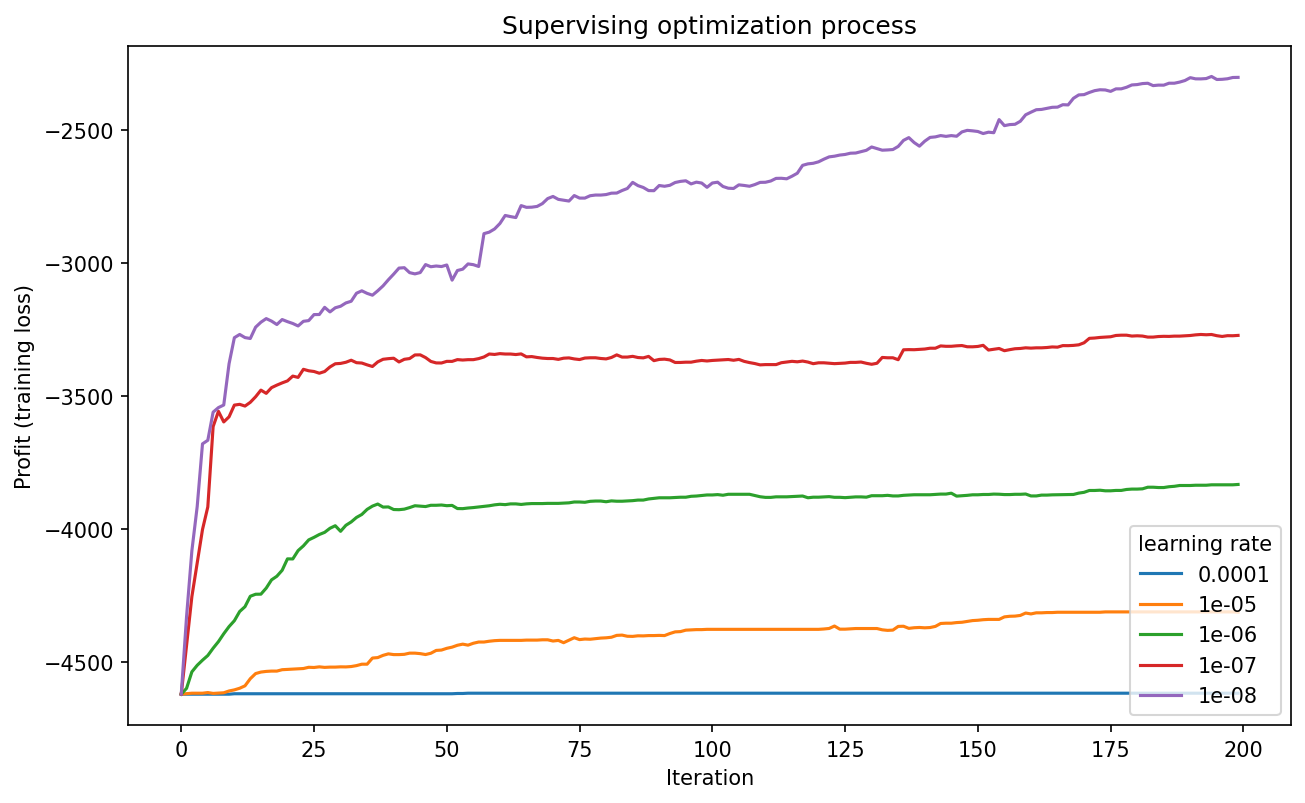

In [ ]:
# Setting up figure size and resolution
plt.figure(num=1, figsize=(10, 6), dpi=150, facecolor='w', edgecolor='k')

# Plotting training loss through iterations
for i in range(len(profit_iter_matrix)):
  plt.plot(profit_iter_matrix[i], label=lr_vec[i])  
plt.ylabel("Profit (training loss)")
plt.xlabel("Iteration")
plt.title(f"Supervising optimization process")
plt.legend(title='learning rate', loc='lower right')
plt.show()

Text(0.5, 0.98, 'Validation vs. training accuracy')

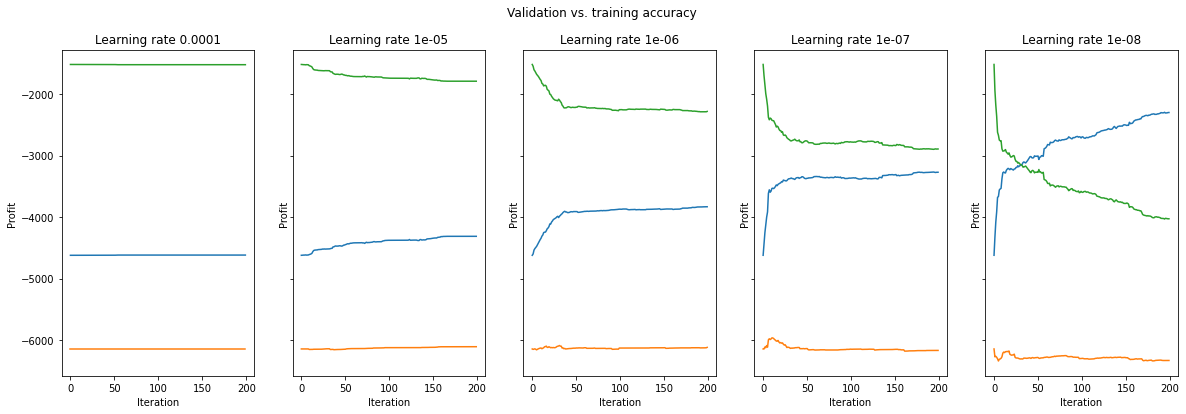

In [ ]:
# Initialize (1,n) subplots
fig, axs = plt.subplots(1, len(lr_vec), sharey=True, figsize=(20,6))

# Plot each subplot
for i in range(len(lr_vec)):
  train_acc = np.asarray(profit_iter_matrix[i])
  val_acc = np.asarray(profit_history_matrix[i])
  diff = np.abs(train_acc) - np.abs(val_acc)

  axs[i].plot(train_acc)
  axs[i].plot(val_acc)
  axs[i].plot(diff)

  axs[i].set_xlabel("Iteration")
  axs[i].set_ylabel("Profit")
  axs[i].set_title(f"Learning rate {lr_vec[i]}")

fig.suptitle("Validation vs. training accuracy")

